In [ ]:
############ If you are not running the codes in Colab but in your own device, you can skip the first three cells
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
#https://towardsdatascience.com/3-ways-to-load-csv-files-into-colab-7c14fcbdcb92
## We have two datasets and we download them into Colab

id = '16NQGuP1S5NVZdCzy8BAdzsrdHzvJucOD'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('GKX_20201231.csv')


In [ ]:
id2 = '1YmTrkE_CSAe4D7StdupnTdrhBBUHCtIp'
downloaded = drive.CreateFile({'id':id2}) 
downloaded.GetContentFile('PredictorData2020.csv')


In [2]:
## Restart runtime in Colab at this point to release memory before running the below codes
## Make sure the two data files have been saved in Colab or in the directory
import pandas as pd
import gc
import numpy as np
import math
import lightgbm as lgb
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import gc
import warnings
from tqdm import tqdm

In [ ]:
# Import the data set, either from local directory or Colab space
df = pd.read_csv('GKX_20201231.csv',sep=',')

In [ ]:
########################################################################
####################### 1. Data Processing #############################
########################################################################
# The dimension & column names
print(df.shape)
df.columns

# All columns are either numeric or dummy variables for different categories
print(df.select_dtypes('object').shape[1])

# We note the data actually start from 1926
# while the paper used data from Mar-1957

# We filter out data earlier than Feb-1957 and later than Dec-2016
# Feb-1957 is kept for first return calculation
df = df[(df['DATE'] > 19570228)].reset_index().iloc[:,1:]
df = df[(df['DATE'] // 10000 < 2017)].reset_index().iloc[:,1:]

# Transform the date format of the stock data set into yyyymm
df['DATE'] = df['DATE'] // 100
df = df.rename(columns={'DATE': 'yyyymm'})


In [ ]:
# We know that among the 101 columns, 94 are stock level characteristics
# The sic2 column corresponds to the industry variable
# The other six columns are not used for prediction, according to the appendix of the paper
for i in range(0,len(df.columns)):
    if 10*i < len(df.columns):
        print(df.columns.sort_values()[(10*i):(min(len(df.columns),10*(i+1)))])

## The six columns are ['DATE','RET','SHROUT','mve0','prc','permno']


In [ ]:
############## Import the other dataset mentioned by the author from Welch and Goyal(2008)

# This contains the macroeconomic factors he constructed
# https://sites.google.com/view/agoyal145
# https://drive.google.com/file/d/1ACbhdnIy0VbCWgsnXkjcddiV8HF4feWv/view
df2 = pd.read_csv("PredictorData2020.csv",sep=",")
df2 = df2[df2['yyyymm']>=195703].reset_index().iloc[:,1:]

# Note the index was stored as object
df2.dtypes
# First remove the "," in the index level stored as string
for i in range(0,len(df2['Index'])):
    df2['Index'][i] = df2['Index'][i].replace(',','')
# Then change the index level back to float
df2['Index'] = df2['Index'].apply(float)
df2.dtypes
    
# Compute dividend to price ratio
df2['dp_SnP'] = df2['D12'].apply(math.log) - df2['Index'].apply(math.log)
# Compute earnings to price ratio
df2['ep_SnP'] = df2['E12'].apply(math.log) - df2['Index'].apply(math.log)
# Compute the default yield spread
df2['dfy'] = df2['BAA'] - df2['AAA']
# Term spread = Long term yield - t-bill rate
df2['tms'] = df2['lty'] - df2['tbl']

# Rename the book-to-market ratio since there is another variable of the exact same name in the core dataset
df2 = df2.rename(columns={'b/m': 'bm_DJI'})

# Keep only the eight variables needed
lst = ['yyyymm','dp_SnP','ep_SnP','bm_DJI','ntis','tbl','tms','dfy','svar']
df2 = df2[lst]
# Force the date to be integer values
df2['yyyymm'] = df2['yyyymm'].astype('int')
#df2.head()
#df2.tail()

In [ ]:
## We join the two datasets by the date column.ie yyyymm

# Create a column to store the values
df['tbl'] = np.zeros(df.shape[0])
df['dp_SnP'] = np.zeros(df.shape[0])
df['ep_SnP'] = np.zeros(df.shape[0])
df['bm_DJI'] = np.zeros(df.shape[0])
df['ntis'] = np.zeros(df.shape[0])
df['tms'] = np.zeros(df.shape[0])
df['dfy'] = np.zeros(df.shape[0])
df['svar'] = np.zeros(df.shape[0])

# Store the number of months
period_list = np.unique(df['yyyymm'])
num_months = len(period_list)

current_row = 0
for period in period_list:
    #Store the number stocks with data in the period
    n_period = df[df['yyyymm']==period].shape[0]
    #Record the position of the macro variable in the period
    tmp = df2[df2['yyyymm']==period].index[0]

    # fill in the macro variables for the stock at that period
    # Since the data have been sorted, we can assign values by multiple rows at a time
    df.loc[current_row:(current_row+n_period-1),'tbl'] = float(df2.loc[tmp,'tbl'])
    df.loc[current_row:(current_row+n_period-1),'dp_SnP'] = float(df2.loc[tmp,'dp_SnP'])
    df.loc[current_row:(current_row+n_period-1),'ep_SnP'] = float(df2.loc[tmp,'ep_SnP'])
    df.loc[current_row:(current_row+n_period-1),'bm_DJI'] = float(df2.loc[tmp,'bm_DJI'])
    df.loc[current_row:(current_row+n_period-1),'ntis'] = float(df2.loc[tmp,'ntis'])
    df.loc[current_row:(current_row+n_period-1),'tms'] = float(df2.loc[tmp,'tms'])
    df.loc[current_row:(current_row+n_period-1),'dfy'] = float(df2.loc[tmp,'dfy'])
    df.loc[current_row:(current_row+n_period-1),'svar'] = float(df2.loc[tmp,'svar'])
    
    current_row = current_row + n_period
  

del(df2)
gc.collect()

# After merging compute the excess return
df['excess_return'] = df['RET'] - df['tbl']       

#print(df[['permno','yyyymm','tbl','excess_return','svar']].head())
#df[['permno','yyyymm','tbl','excess_return','svar']].tail()


In [ ]:
print(df.shape)
# Note the df has 107 float variables and 3 integer variable
print(df.dtypes[df.dtypes=='int64'])
len(df.dtypes[df.dtypes=='float64'])

In [ ]:
# Here we check the ranges of the variables,
# because later we want to save memory in later parts
# We are trading off precision via converting float64 to float32, int64 to int32
lst = df.columns
arith_range_lst = np.max(df[lst])-np.min(df[lst])
print(arith_range_lst.sort_values(ascending=False))


In [ ]:
int_var = ['permno','yyyymm','SHROUT']
float_var = [x for x in df.columns if x not in int_var]

# Convert these two to in32
df[['permno','yyyymm']] = df[['permno','yyyymm']].astype('uint32')

# Since float32 covers the range of these variables well, we convert it from float64
for col in float_var:
    df[col] = df[col].astype('float32')
df.dtypes

In [ ]:
print(np.max(df['mvel1']))
print(np.max(df['ill']))
print(np.min(df['ill']))
df.dtypes
print(np.max(df['yyyymm']))
print(np.max(df['yyyymm']))
print(np.min(df['yyyymm']))

In [ ]:
#### In this part we will fill the missing values of each of the 94 stock characteristics with cross-sectional median

macro = ['dp_SnP','ep_SnP','bm_DJI','ntis','tbl','tms','dfy','svar']
non_predictor = ['yyyymm','RET','SHROUT','mve0','prc','permno','excess_return']
industry = ['sic2']
lst = macro + non_predictor + industry
# Get the 94 column names of the stock characteristics
stock_char = [x for x in df.columns if x not in lst]

#Store the distinct numbers of period
period_list = np.unique(df['yyyymm'])
len(stock_char)
len(period_list)

# We know that for some variables in some period, all values may be missing for all
## stocks
# We thus filter out this anticipated warnings
warnings.filterwarnings(action='ignore', message='All-NaN slice encountered')

## Note that this step takes relatively long as it loops through all 
## data point and do assignment in case of missing values
## Around 20-30 minutes on Colab is needed

for char in stock_char:
    current_row = 0
    for period in period_list:
        # Store the number of stocks in the period
        n_period = df[df['yyyymm']==period].shape[0]
        # Get the cross-sectional median of this stock characteristic
        crx_median_char = np.nanmedian(df.loc[current_row:(current_row+n_period-1),char])
        # Replace missing values with median
        df.loc[current_row:(current_row+n_period-1),char] = df.loc[current_row:(current_row+n_period-1),char].replace(np.nan,crx_median_char)
        current_row = current_row + n_period

In [ ]:
## Check for missing values after the above process
## For some variables, some have missing values for all stock in a period
for char in df.columns:
    print(len(df[df[char].isnull()].index.tolist()))


In [ ]:
####################### Handling Industries Dummy Variables####################
# Taking the first two digits of SIC2 for industry
df['sic2'] = df['sic2'].apply(np.floor)

# Check whether there are 74 industries as said in the paper
#df.groupby('sic2').count().iloc[:,0:1] 
df['sic2'] = df['sic2'].astype(str)
len(np.unique(df['sic2']))
np.unique(df['sic2'])

In [ ]:
# Convert the industries to dummies variable
df = pd.get_dummies(df)

In [ ]:
## Note that the lags have already been adjusted in the data set provided
## we will not need any shifting of observations

# Drop the variables that will no longer be used
df = df.drop(columns=['RET','prc','SHROUT','mve0'])
df.shape

In [ ]:
df.to_csv("df_merge_fill.csv",index=False)

In [ ]:
df = pd.read_csv("df_merge_fill.csv",sep=',')

In [ ]:
macro = ['dp_SnP','ep_SnP','bm_DJI','ntis','tbl','tms','dfy','svar']
non_predictor = ['yyyymm','RET','SHROUT','mve0','prc','permno','excess_return']
industry = ['sic2']
lst = macro + non_predictor + industry
df.shape
stock_char = [x for x in df.columns[:105] if x not in lst]
len(stock_char)

In [ ]:
## As said in the paper
# we normalize the stock data by the cross-sectional mean and variance
# before we put them into neural network training
# The macro variable is the same in one cross-section, so we skip this for the 8 macros
# The process takes long (about 20-30 mins)

period_list = np.unique(df['yyyymm'])
len(period_list)

for char in stock_char:
    current_row = 0
    for period in period_list:
        # Store the number of stocks in the period
        n_period = df[df['yyyymm']==period].shape[0]
        # Get the cross-sectional mean and sd of this stock characteristic
        crx_mean_char = np.nanmean(df.loc[current_row:(current_row+n_period-1),char])
        crx_std_char = np.nanstd(df.loc[current_row:(current_row+n_period-1),char])
        
        # De-mean and re-scale the data by cross-sectional mean and sd
        # Only do so for a cross section with non-missing values
        if (not(np.isnan(crx_mean_char) or np.isnan(crx_std_char))):
            df.loc[current_row:(current_row+n_period-1),char] = (df.loc[current_row:(current_row+n_period-1),char] - crx_mean_char)/crx_std_char
            current_row = current_row + n_period

#np.nanmean(df.loc[2000:200000,'bm_ia'])


In [204]:
df.to_csv("df_merge_fill_demean.csv",index=False)

In [6]:
df = pd.read_csv("df_merge_fill_demean.csv",sep=',')
#df = df.fillna(0)

In [7]:
df.shape
#df.dtypes
#gc.collect()

(3760033, 180)

In [305]:
####################################################################################################
##################################### 5. Neural Network#############################################
####################################################################################################
import torch
from torch.nn import Module
from torch import nn
from torch.optim import Adam
from torch.nn import MSELoss
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.metrics import r2_score

use_gpu = False
device = torch.device("cuda" if use_gpu else "cpu")
print(device)

cpu


In [433]:
# Define the NN1
class NN1(Module):
    def __init__(self, input_size, hidden_size):
        super(NN1, self).__init__()
        self.input_size = input_size
        self.hidden_size  = hidden_size
        self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size)
        self.relu = torch.nn.ReLU()
        self.bn1 = nn.BatchNorm1d(self.hidden_size)
        self.output = nn.Linear(self.hidden_size, 1)
    def forward(self, x):
        hidden = self.fc1(x)
        relu = self.relu(hidden)
        bn_x = self.bn1(relu)
        output = self.output(bn_x)
        return output

net = NN1(input_size=177, hidden_size=32).to(device)
print(net)

NN1(
  (fc1): Linear(in_features=177, out_features=32, bias=True)
  (relu): ReLU()
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (output): Linear(in_features=32, out_features=1, bias=True)
)


In [349]:
# Define the dataset the pytorch
class stock_data(Dataset):
    def __init__(self, stockdata, predictor_col, mode = 'train'):
        self.mode = mode
        ## During pre-processing of data, missing values have been replaced by cross-sectional median
        ## If they are still missing, this means the variable has missing values in the cross-section for all stocks
        ## So we take such observations as zero
        stockdata_fill = stockdata.fillna(0)
        del(stockdata)
        if self.mode == 'train':
            self.inp = stockdata_fill.loc[:,predictor_col].values
            self.oup = stockdata_fill.loc[:,'excess_return'].values
        else:
            self.inp = stockdata_fill.loc[:,predictor_col].values
    def __len__(self):
        return len(self.inp)
    def __getitem__(self, idx):
        if self.mode == 'train':
            inpt  = torch.from_numpy(np.array(self.inp[idx]).astype('float32'))
            oupt  = torch.from_numpy(np.array(self.oup[idx]).astype('float32'))
            return { 'inp': inpt,
                     'oup': oupt,
            }
        else:
            inpt = torch.from_numpy(np.array(self.inp[idx]))
            return { 'inp': inpt
            }


In [357]:
# Save the predictor list
lst = ['yyyymm','permno','excess_return']
predictor_col = [x for x in df.columns if x not in lst]

In [358]:
year_train_end = 1957+18
year_valid_end = 1957+18+12
year_test_start = 1987
data = stock_data(stockdata=df[df['yyyymm']//100 < year_train_end], predictor_col=predictor_col)
BATCH_SIZE = 10000
data_train = DataLoader(dataset = data, batch_size = BATCH_SIZE, drop_last=True, shuffle=False)
del data

In [359]:
## Define the validation data set
dataset_valid = stock_data(stockdata=df[(df['yyyymm']//100 >= year_train_end) & (df['yyyymm']//100 < year_valid_end)], predictor_col=predictor_col)
data_valid = DataLoader(dataset = dataset_valid, batch_size = BATCH_SIZE, drop_last=True, shuffle=False)
del dataset_valid

In [360]:
## Define the testing data set
dataset_test = stock_data(stockdata=df[(df['yyyymm']//100 >= year_test_start) & (df['yyyymm']//100 < year_test_start+1)], predictor_col=predictor_col)
data_test = DataLoader(dataset = dataset_test, batch_size = BATCH_SIZE, drop_last=True, shuffle=False)
del dataset_test

In [16]:
#### This is a trial of one-snapshot feature importance

year1 = 1957
year2 = 2004
index_start = np.min(df[df['yyyymm']//100 >=year1].index.to_list())
index_end = np.max(df[df['yyyymm']//100 <=year2].index.to_list())
print(index_start)
index_end

net = NN1(input_size=177, hidden_size=32).to(device)
net.load_state_dict(torch.load("NN1_2016_end.pt"))

0


<All keys matched successfully>

In [291]:
def train(model, x, y, optimizer, criterion, lambda_reg):
    model.zero_grad()
    output = model(x)
    loss =criterion(output,y)
    l1_norm = sum(abs(p).sum() for p in model.parameters())
    loss += lambda_reg * l1_norm
    loss.backward()
    optimizer.step()
    return loss, output

def valid(model, x_valid, y_valid):
    output = model(x_valid)
    error = output.view(-1,1) - y_valid.view(-1,1)
    sum_resid_error = torch.sum(error*error)
    sum_sq = torch.sum(y_valid*y_valid)
    return sum_resid_error, sum_sq

In [292]:
## Define the general training function for our neural networks

def train_model(model, data_train, data_valid, learning_rate, l1_lambda, epsilon, printout):
    #Parameters/setting that will be fixed as with the paper
    EPOCHS = 100
    optimizer = Adam(model.parameters(),lr=learning_rate)
    criterion = MSELoss()
    patience = 5
    
    # The variable for detecting early-stopping
    ## Initialize the variable to store the best validation R_2 in training and the number of times no improvement 
    ## above threshold - epsilon
    j = 0
    best_r_sq_up_to_now = -500000
    
    for epoch in range(EPOCHS):
        epoch_loss = 0
        for bidx, batch in enumerate(data_train):
            x_train, y_train = batch['inp'], batch['oup']
            x_train = x_train.view(-1,177)
            x_train = x_train.to(device)
            y_train = y_train.view(-1,1)
            y_train = y_train.to(device)
            loss, predictions = train(model,x_train,y_train, optimizer, criterion, l1_lambda)
            epoch_loss+=loss
        if (printout == True):
            print('Epoch {} : Training MSE Loss : {}'.format((epoch+1),epoch_loss))
        
        running_sum_sq_error = 0
        running_sum_sq = 0
        for bidx, batch in enumerate(data_valid):
            x_valid, y_valid  = batch['inp'], batch['oup']
            x_valid = x_valid.view(-1,177)
            x_valid = x_valid.to(device)
            y_valid = y_valid.view(-1,1)
            y_valid = y_valid.to(device)
            sum_resid_error, sum_sq = valid(model, x_valid, y_valid)
            running_sum_sq += sum_sq
            running_sum_sq_error += sum_resid_error
        R_sq_oos = 1 - running_sum_sq_error/running_sum_sq
        if (printout == True):
            print('Epoch {} Validation R^2_oos : {}'.format((epoch+1),R_sq_oos))

        if (R_sq_oos > best_r_sq_up_to_now):
            if (R_sq_oos <= best_r_sq_up_to_now + epsilon):
                best_r_sq_up_to_now = R_sq_oos
                j += 1
            else:
                best_r_sq_up_to_now = R_sq_oos
                j = 0
        else:
            j +=1
        if (j >= patience):
            if (printout == True): 
                print('Early stopping triggered and the best validation R^2: {}'.format(best_r_sq_up_to_now))
            break
    if (printout == True):
        print('Trainin stopped after {} epochs'.format(epoch+1))

    

In [103]:
################## Specify the parameters for NN1

### Training for NN1
learning_rate = 5e-3
# l1 regularization
l1_lambda = 1e-4

## We will regularize the model by early stopping with patience p = 5; epsilon = 0.01
## That is, we will break the loop when the R-square in the validation set cannot improve by more than 0.005 in 5 epochs
epsilon = 0.0005

train_model(net, data_train, data_valid, learning_rate, l1_lambda, epsilon, printout=True)

Epoch 1 : Training MSE Loss : 2.2216711044311523
Epoch 1 Validation R^2_oos : 0.008648812770843506
Epoch 2 : Training MSE Loss : 1.6966581344604492
Epoch 2 Validation R^2_oos : 0.059522032737731934
Epoch 3 : Training MSE Loss : 1.5079433917999268
Epoch 3 Validation R^2_oos : 0.0798293948173523
Epoch 4 : Training MSE Loss : 1.4520869255065918
Epoch 4 Validation R^2_oos : 0.09413975477218628
Epoch 5 : Training MSE Loss : 1.3866275548934937
Epoch 5 Validation R^2_oos : 0.10377782583236694
Epoch 6 : Training MSE Loss : 1.2993717193603516
Epoch 6 Validation R^2_oos : 0.12315541505813599
Epoch 7 : Training MSE Loss : 1.2304725646972656
Epoch 7 Validation R^2_oos : 0.1244896650314331
Epoch 8 : Training MSE Loss : 1.1957405805587769
Epoch 8 Validation R^2_oos : 0.12963330745697021
Epoch 9 : Training MSE Loss : 1.1854984760284424
Epoch 9 Validation R^2_oos : 0.12779444456100464
Epoch 10 : Training MSE Loss : 1.152513027191162
Epoch 10 Validation R^2_oos : 0.1329948902130127
Epoch 11 : Training 

In [293]:
## Define the test function
def test(model, x_test, y_test):
    output = model(x_test)
    error = output.view(-1,1) - y_test.view(-1,1)
    sum_resid_error = torch.sum(error*error)
    sum_sq = torch.sum(y_test*y_test)
    return sum_resid_error, sum_sq
 

In [387]:
# Define a general testing loop for all NN_i models, for i = 1,2, ...,5
def test_model(model, data_test):
    running_sum_sq_error = 0
    running_sum_sq = 0
    for bidx, batch in enumerate(data_test):
        x_test, y_test  = batch['inp'], batch['oup']
        x_test = x_test.view(-1,177)
        x_test = x_test.to(device)
        y_test = y_test.view(-1,1)
        y_test = y_test.to(device)
        sum_resid_error, sum_sq = test(model, x_test, y_test)
        running_sum_sq += sum_sq
        running_sum_sq_error += sum_resid_error
    #print('R_sq_oos in the tested year:')
    R_sq_oos = 1 - running_sum_sq_error/running_sum_sq
    return R_sq_oos


In [114]:
torch.save(net.state_dict(), "NN1.pt")

In [74]:
net = NN1(input_size=177, hidden_size=32).to(device)
net.load_state_dict(torch.load("NN1.pt"))

<All keys matched successfully>

In [17]:
test_model(net, data_test)

R_sq_oos in the following year:


tensor(0.1176, grad_fn=<RsubBackward1>)

In [19]:
# Define a recursive training loop for NN1
BATCH_SIZE = 10000
### Training for NN1
learning_rate = 5e-3
# l1 regularization
l1_lambda = 1e-4
epsilon = 0.0005

for year in range(1975,2005):
    data = stock_data(stockdata=df.loc[df['yyyymm']//100 <= year,:].reset_index().iloc[:,1:], predictor_col=predictor_col)
    data_train = DataLoader(dataset = data, batch_size = BATCH_SIZE, drop_last=True, shuffle=False)
    dataset_valid = stock_data(stockdata=df.loc[((df['yyyymm']//100 > year)&(df['yyyymm']//100 <= year+12)),:].reset_index().iloc[:,1:], predictor_col=predictor_col)
    data_valid = DataLoader(dataset = dataset_valid, batch_size = BATCH_SIZE, drop_last=True, shuffle=False)
    
    net = NN1(input_size=177, hidden_size=32).to(device)
    train_model(net, data_train, data_valid, learning_rate, l1_lambda, epsilon, printout=False)
    del(data)
    del(data_train)
    del(dataset_valid)
    del(data_valid)
    gc.collect()
    
    filename = "NN1_" + str(year+12) + "_end.pt"
    print(filename)
    torch.save(net.state_dict(), filename)
`

NN1_1987_end.pt
NN1_1988_end.pt
NN1_1989_end.pt
NN1_1990_end.pt
NN1_1991_end.pt
NN1_1992_end.pt
NN1_1993_end.pt
NN1_1994_end.pt
NN1_1995_end.pt
NN1_1996_end.pt
NN1_1997_end.pt
NN1_1998_end.pt
NN1_1999_end.pt
NN1_2000_end.pt
NN1_2001_end.pt
NN1_2002_end.pt
NN1_2003_end.pt
NN1_2004_end.pt
NN1_2005_end.pt
NN1_2006_end.pt
NN1_2007_end.pt
NN1_2008_end.pt
NN1_2009_end.pt
NN1_2010_end.pt
NN1_2011_end.pt
NN1_2012_end.pt
NN1_2013_end.pt
NN1_2014_end.pt
NN1_2015_end.pt
NN1_2016_end.pt


In [459]:
R_sq_list_NN1 = []
#cum_feat_imp_NN1 = np.zeros(len(predictor_col))

for year in range(1987,2016):
    
    net1 = NN1(input_size=177, hidden_size=32).to(device)
    filename = "NN1_" + str(year) + "_end.pt"
    net1.load_state_dict(torch.load(filename))
    year_test_start = year
    
    # Note the coming 12 years of data are for validation but not for testing or model estimates
    # So we test the model fitted with 1957-1974 data with 1987 data, and so on
    dataset_test = stock_data(stockdata=df[((df['yyyymm']//100 >= year_test_start) & (df['yyyymm']//100 < year_test_start+1))], predictor_col=predictor_col)
    data_test = DataLoader(dataset = dataset_test, batch_size = BATCH_SIZE, drop_last=True, shuffle=False)
    del dataset_test
    
    # Save the R_sq_oos for each year
    R_sq_oos = test_model(net1, data_test).item()
    R_sq_list_NN1.append(R_sq_oos)
    del(data_test)
    
    # At the same time we find the feature importance of the net
    
    year_train_end = year-12
    data = stock_data(stockdata=df[df['yyyymm']//100 < year_train_end], predictor_col=predictor_col)
    BATCH_SIZE = 10000
    data_train = DataLoader(dataset = data, batch_size = BATCH_SIZE, drop_last=True, shuffle=False)
    del(data)
    cum_feat_imp_NN4 += feat_imp_net(net4, data_train)
    del(data_train)
    print("Year {} completed".format(year))
    
R_sq_list_NN1

Year 1987 completed
Year 1988 completed
Year 1989 completed
Year 1990 completed
Year 1991 completed
Year 1992 completed
Year 1993 completed
Year 1994 completed
Year 1995 completed
Year 1996 completed
Year 1997 completed
Year 1998 completed
Year 1999 completed
Year 2000 completed
Year 2001 completed
Year 2002 completed
Year 2003 completed
Year 2004 completed
Year 2005 completed
Year 2006 completed
Year 2007 completed
Year 2008 completed
Year 2009 completed
Year 2010 completed
Year 2011 completed
Year 2012 completed
Year 2013 completed
Year 2014 completed
Year 2015 completed


[0.09770667552947998,
 0.08060711622238159,
 0.1437341570854187,
 0.11548066139221191,
 0.002632617950439453,
 -0.022261857986450195,
 -0.11080455780029297,
 -0.013328194618225098,
 -0.11183226108551025,
 -0.08114683628082275,
 -0.040172457695007324,
 0.0436328649520874,
 -0.009955883026123047,
 0.05666869878768921,
 -0.0200042724609375,
 -0.04290151596069336,
 -0.2799196243286133,
 -0.12814664840698242,
 0.04209405183792114,
 0.04735046625137329,
 0.10398834943771362,
 0.09305596351623535,
 -0.07486248016357422,
 -0.16078686714172363,
 -0.058098793029785156,
 -0.12744951248168945,
 -0.22547292709350586,
 -0.09148252010345459,
 -0.010153412818908691]

In [460]:
NN1_R2 = np.array(R_sq_list_NN1)
print(np.mean(NN1_R2))
print(np.median(NN1_R2))
print(np.max(NN1_R2))

print(np.mean(NN1_R2[0:9]))
print(np.median(NN1_R2[0:9]))
print(np.max(NN1_R2[0:9]))


-0.02695962067308097
-0.0200042724609375
0.1437341570854187
0.02021492852105035
0.002632617950439453
0.1437341570854187


In [361]:
##### Define the class for NN2

class NN2(Module):
    def __init__(self, input_size, hidden_size_1, hidden_size_2):
        super(NN2, self).__init__()
        self.input_size = input_size
        self.hidden_size_1  = hidden_size_1
        self.hidden_size_2  = hidden_size_2
        self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size_1)
        self.relu = torch.nn.ReLU()
        self.bn1 = nn.BatchNorm1d(self.hidden_size_1)
        self.fc2 = torch.nn.Linear(self.hidden_size_1, self.hidden_size_2)
        self.bn2 = nn.BatchNorm1d(self.hidden_size_2)
        self.output = nn.Linear(self.hidden_size_2, 1)
    def forward(self, x):
        hidden = self.fc1(x)
        relu = self.relu(hidden)
        bn_x = self.bn1(relu)
        hidden = self.fc2(bn_x)
        relu = self.relu(hidden)
        bn_x = self.bn2(relu)       
        output = self.output(bn_x)
        return output

net2 = NN2(input_size=177, hidden_size_1=32, hidden_size_2=16).to(device)
print(net2)

NN2(
  (fc1): Linear(in_features=177, out_features=32, bias=True)
  (relu): ReLU()
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=32, out_features=16, bias=True)
  (bn2): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (output): Linear(in_features=16, out_features=1, bias=True)
)


In [362]:
### Training for a single NN2 for a trial
### The rationale is similar to that of NN1
learning_rate = 5e-3
# l1 regularization
l1_lambda = 1e-5
epsilon = 0.0005

train_model(net2, data_train, data_valid, learning_rate, l1_lambda, epsilon, printout=True)

Epoch 1 : Training MSE Loss : 2.276771306991577
Epoch 1 Validation R^2_oos : 0.015022873878479004
Epoch 2 : Training MSE Loss : 1.2826963663101196
Epoch 2 Validation R^2_oos : 0.031631529331207275
Epoch 3 : Training MSE Loss : 1.0725053548812866
Epoch 3 Validation R^2_oos : 0.0585179328918457
Epoch 4 : Training MSE Loss : 1.032969355583191
Epoch 4 Validation R^2_oos : 0.0776473879814148
Epoch 5 : Training MSE Loss : 0.98606938123703
Epoch 5 Validation R^2_oos : 0.09348207712173462
Epoch 6 : Training MSE Loss : 0.9709440469741821
Epoch 6 Validation R^2_oos : 0.09754437208175659
Epoch 7 : Training MSE Loss : 0.9373044371604919
Epoch 7 Validation R^2_oos : 0.10720998048782349
Epoch 8 : Training MSE Loss : 0.9285129904747009
Epoch 8 Validation R^2_oos : 0.10986757278442383
Epoch 9 : Training MSE Loss : 0.9225953221321106
Epoch 9 Validation R^2_oos : 0.11343425512313843
Epoch 10 : Training MSE Loss : 0.9171926379203796
Epoch 10 Validation R^2_oos : 0.11591613292694092
Epoch 11 : Training MS

In [363]:
test_model(net2, data_test).item()

R_sq_oos in the following year:


0.09917950630187988

In [336]:
## Select one model to test for a trial
net2 = NN2(input_size=177, hidden_size_1=32, hidden_size_2=16).to(device)
net2.load_state_dict(torch.load("NN2_1988_end.pt"))
year_test_start = 1988
dataset_test = stock_data(stockdata=df[(df.loc[:,'yyyymm']//100 >= year_test_start) & (df['yyyymm']//100 < year_test_start+1)], predictor_col=predictor_col)
data_test = DataLoader(dataset = dataset_test, batch_size = BATCH_SIZE, drop_last=True, shuffle=False)
del dataset_test
test_model(net2, data_test)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, val, pi)


R_sq_oos in the following year:


tensor(0.0797, grad_fn=<RsubBackward1>)

In [ ]:
# Define a recursive training loop for NN2
BATCH_SIZE = 10000
### Training for NN2
learning_rate = 5e-3
# l1 regularization
l1_lambda = 1e-4
epsilon = 0.0005

# Here year represents 
for year in range(1974,2005):
    data = stock_data(stockdata=df.loc[df['yyyymm']//100 < year,:].reset_index().iloc[:,1:], predictor_col=predictor_col)
    data_train = DataLoader(dataset = data, batch_size = BATCH_SIZE, drop_last=True, shuffle=False)
    del(data)
    
    dataset_valid = stock_data(stockdata=df.loc[((df['yyyymm']//100 >= year)&(df['yyyymm']//100 < year+12)),:].reset_index().iloc[:,1:], predictor_col=predictor_col)
    data_valid = DataLoader(dataset = dataset_valid, batch_size = BATCH_SIZE, drop_last=True, shuffle=False)
    del(dataset_valid)
    
    net = NN2(input_size=177, hidden_size_1=32, hidden_size_2=16).to(device)
    train_model(net, data_train, data_valid, learning_rate, l1_lambda, epsilon, printout=False)
    
    del(data_train)
    del(data_valid)
    gc.collect()
    
    filename = "NN2_" + str(year+12) + "_end.pt"
    print(filename)
    torch.save(net.state_dict(), filename)
    del(net)

In [480]:
# Define a function to find the feature importance

def feat_imp_net(model, data_train):
    
    R_sq_loss_table = np.zeros(len(predictor_col))
    
    x = np.array(data_train.dataset.inp[:])
    y = torch.from_numpy(np.array(data_train.dataset.oup[:]).astype('float32')).view(-1,1)
    y = y.to(device)
    x_o = torch.from_numpy(np.array(data_train.dataset.inp[:]).astype('float32')).to(device)
    del(data_train)
    gc.collect()

    y_predict = model(x_o).view(-1,1)
    a = y.view(-1,1) - y_predict
    R_sq_full_model = 1 - sum(a*a)/sum(y*y)

    for i in range(0,len(predictor_col)):
        tmp = np.array(x[:,i])
        x[:,i] = np.zeros(x.shape[0])
        x_twisted = torch.from_numpy(x.astype('float32')).to(device)
        y_predict = model(x_twisted).view(-1,1)
        error = y - y_predict
        R_sq_twisted = 1 - sum(error*error)/sum(y*y)
        R_sq_loss_table[i] = R_sq_full_model-R_sq_twisted
        # Restore the original values of predictor i
        x[:,i] = tmp
        if (i%80 == 0):
            print(i)
    #R_sq_loss_table = R_sq_loss_table/sum(R_sq_loss_table) #Do not use this since sometimes sum could be close to zero
    
    return R_sq_loss_table
#zipped = zip(predictor_col,R_sq_loss_table)
#list(zipped)

In [462]:
R_sq_list_NN2 = []
#cum_feat_imp_NN2 = np.zeros(len(predictor_col))

for year in range(1987,2016):
    
    net2 = NN2(input_size=177, hidden_size_1=32, hidden_size_2=16).to(device)
    filename = "NN2_" + str(year) + "_end.pt"
    net2.load_state_dict(torch.load(filename))
    year_test_start = year
    
    # Note the coming 12 years of data are for validation but not for testing or model estimates
    # So we test the model fitted with 1957-1974 data with 1987 data, and so on
    dataset_test = stock_data(stockdata=df[((df['yyyymm']//100 >= year_test_start) & (df['yyyymm']//100 < year_test_start+1))], predictor_col=predictor_col)
    data_test = DataLoader(dataset = dataset_test, batch_size = BATCH_SIZE, drop_last=True, shuffle=False)
    del dataset_test
    
    # Save the R_sq_oos for each year
    R_sq_oos = test_model(net2, data_test).item()
    R_sq_list_NN2.append(R_sq_oos)
    del(data_test)
    
    # At the same time we find the feature importance of the net
    year_train_end = year-12
    data = stock_data(stockdata=df[df['yyyymm']//100 < year_train_end], predictor_col=predictor_col)
    BATCH_SIZE = 10000
    data_train = DataLoader(dataset = data, batch_size = BATCH_SIZE, drop_last=True, shuffle=False)
    del(data)
    cum_feat_imp_NN2 += feat_imp_net(net2, data_train)
    del(data_train)
    print("Year {} completed".format(year))
    
R_sq_list_NN2

Year 1987 completed
Year 1988 completed
Year 1989 completed
Year 1990 completed
Year 1991 completed
Year 1992 completed
Year 1993 completed
Year 1994 completed
Year 1995 completed
Year 1996 completed
Year 1997 completed
Year 1998 completed
Year 1999 completed
Year 2000 completed
Year 2001 completed
Year 2002 completed
Year 2003 completed
Year 2004 completed
Year 2005 completed
Year 2006 completed
Year 2007 completed
Year 2008 completed
Year 2009 completed
Year 2010 completed
Year 2011 completed
Year 2012 completed
Year 2013 completed
Year 2014 completed
Year 2015 completed


[0.09726208448410034,
 0.07974183559417725,
 0.14403396844863892,
 0.11529743671417236,
 0.0006988048553466797,
 -0.0067746639251708984,
 -0.046611905097961426,
 0.04551297426223755,
 -0.10236501693725586,
 -0.07226836681365967,
 -0.10307204723358154,
 0.024225950241088867,
 -0.02914905548095703,
 0.056396543979644775,
 -0.011753320693969727,
 -0.014590859413146973,
 -0.30480706691741943,
 -0.2521495819091797,
 0.018039405345916748,
 0.05874842405319214,
 0.06871652603149414,
 0.07689827680587769,
 -0.06861937046051025,
 -0.12308287620544434,
 -0.06620633602142334,
 -0.14722275733947754,
 -0.18053078651428223,
 -0.13116776943206787,
 -0.03563892841339111]

In [463]:
print(np.mean(R_sq_list_NN2))
print(np.median(R_sq_list_NN2))
print(np.max(R_sq_list_NN2))
print(np.mean(R_sq_list_NN2[0:9]))
print(np.median(R_sq_list_NN2[0:9]))
print(np.max(R_sq_list_NN2[0:9]))



-0.03139443027562108
-0.014590859413146973
0.14403396844863892
0.03631061315536499
0.04551297426223755
0.14403396844863892


In [412]:
#NN2_R2  <---- this store the R_sq_oos in 1987-2005 testing
#NN2_R2_2 = R_sq_list #<---- this store the R_sq_oos in 1987-2004 testing
NN3_R2
#NN3_feat_imp = np.array(cum_feat_imp)

array([ 9.76138928e-05, -8.58663205e-05, -1.30268722e-04, -2.35505303e-05,
        1.38845916e-05, -9.60900135e-05, -1.99179611e-05,  7.13440704e-05,
       -1.65091730e-04, -6.56199577e-05, -3.16919931e-05, -1.52136351e-05,
       -3.21786871e-05, -1.15240922e-06, -4.46045079e-07,  7.98237206e-06,
        1.29071817e-04, -5.31195989e-05,  1.66734820e-03,  6.05054165e-05,
        2.13447898e-04, -1.54543038e-05, -1.32480065e-05, -1.73805284e-06,
       -5.63375576e-06,  8.42963270e-05,  4.25364883e-05,  5.37040919e-05,
       -7.74076341e-06, -2.08652357e-06,  7.27006737e-06, -1.00993498e-05,
        1.25832490e-05, -1.14319104e-05,  2.76565277e-05, -3.06495031e-06,
       -1.92018410e-05,  5.76362455e-06,  3.92099551e-05,  1.96872692e-05,
        1.83859525e-04,  1.46656128e-05,  5.26802892e-02, -2.20630890e-05,
       -6.86365285e-07, -3.96165952e-04,  2.45258845e-05, -3.62227929e-05,
       -2.49828671e-05, -1.21814070e-06, -1.74736668e-05,  4.20085458e-05,
       -5.95042163e-05, -

<BarContainer object of 12 artists>

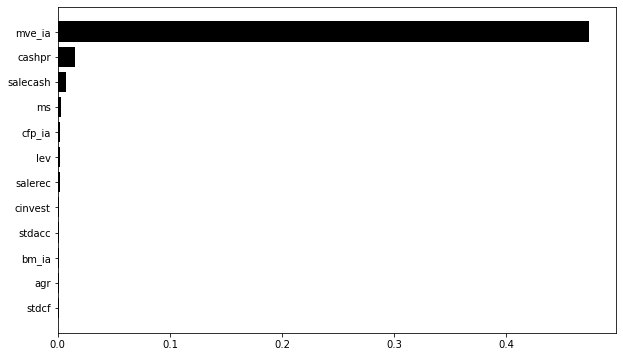

In [414]:
#cum_feat_imp
cum_feat_imp_df = df.loc[0,predictor_col]
cum_feat_imp_df[predictor_col] = cum_feat_imp_NN2/sum(cum_feat_imp_NN2)
cum_feat_imp_df
# PLot the normalized average feature importance in the 30 training samples
feat_imp = cum_feat_imp_df.sort_values(ascending=False)/2
feat_imp_to_plot = feat_imp[0:12].sort_values(ascending=True)

# Plot the feature importances in horizontal bar charts
import matplotlib.pyplot as plt
plt.figure(figsize = (10, 6))
ax = plt.subplot()
ax.barh(list(feat_imp_to_plot.index),
    feat_imp_to_plot, 
    align = 'center', color = 'black')

In [224]:
## Save the model for future use
print("Model's state_dict:")
for param_tensor in net2.state_dict():
    print(param_tensor, "\t", net2.state_dict()[param_tensor].size())

torch.save(net2.state_dict(), "NN2.pt")

Model's state_dict:
fc1.weight 	 torch.Size([32, 177])
fc1.bias 	 torch.Size([32])
bn1.weight 	 torch.Size([32])
bn1.bias 	 torch.Size([32])
bn1.running_mean 	 torch.Size([32])
bn1.running_var 	 torch.Size([32])
bn1.num_batches_tracked 	 torch.Size([])
fc2.weight 	 torch.Size([16, 32])
fc2.bias 	 torch.Size([16])
bn2.weight 	 torch.Size([16])
bn2.bias 	 torch.Size([16])
bn2.running_mean 	 torch.Size([16])
bn2.running_var 	 torch.Size([16])
bn2.num_batches_tracked 	 torch.Size([])
output.weight 	 torch.Size([1, 16])
output.bias 	 torch.Size([1])


In [120]:
net_trial = NN2(input_size=177, hidden_size_1=32, hidden_size_2=16).to(device)
net_trial.load_state_dict(torch.load("NN2.pt"))

<All keys matched successfully>

In [121]:
test_model(net_trial, data_test)

R_sq_oos in the following year:


tensor(0.0822, grad_fn=<RsubBackward1>)

In [415]:
##### Define the class for NN3

class NN3(Module):
    def __init__(self, input_size, hidden_size_1, hidden_size_2, hidden_size_3):
        super(NN3, self).__init__()
        self.input_size = input_size
        self.hidden_size_1  = hidden_size_1
        self.hidden_size_2  = hidden_size_2
        self.hidden_size_3  = hidden_size_3
        self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size_1)
        self.relu = torch.nn.ReLU()
        self.bn1 = nn.BatchNorm1d(self.hidden_size_1)
        self.fc2 = torch.nn.Linear(self.hidden_size_1, self.hidden_size_2)
        self.bn2 = nn.BatchNorm1d(self.hidden_size_2)
        self.fc3 = torch.nn.Linear(self.hidden_size_2, self.hidden_size_3)
        self.bn3 = nn.BatchNorm1d(self.hidden_size_3)
        self.output = nn.Linear(self.hidden_size_3, 1)
    def forward(self, x):
        hidden = self.fc1(x)
        relu = self.relu(hidden)
        bn_x = self.bn1(relu)
        hidden = self.fc2(bn_x)
        relu = self.relu(hidden)
        bn_x = self.bn2(relu)
        hidden = self.fc3(bn_x)
        relu = self.relu(hidden)
        bn_x = self.bn3(relu)
        output = self.output(bn_x)
        return output

net3 = NN3(input_size=177, hidden_size_1=32, hidden_size_2=16, hidden_size_3=8).to(device)
print(net3)

NN3(
  (fc1): Linear(in_features=177, out_features=32, bias=True)
  (relu): ReLU()
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=32, out_features=16, bias=True)
  (bn2): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=16, out_features=8, bias=True)
  (bn3): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (output): Linear(in_features=8, out_features=1, bias=True)
)


In [15]:
### Training for NN3 of a single period
learning_rate = 5e-3
# l1 regularization
l1_lambda = 1e-5
epsilon = 0.0005
train_model(net3, data_train, data_valid, learning_rate, l1_lambda, epsilon, printout=True)

Epoch 1 : Training MSE Loss : 3.543133020401001
Epoch 1 Validation R^2_oos : 0.0006534457206726074
Epoch 2 : Training MSE Loss : 1.265673041343689
Epoch 2 Validation R^2_oos : 0.08968621492385864
Epoch 3 : Training MSE Loss : 1.0433968305587769
Epoch 3 Validation R^2_oos : 0.08780354261398315
Epoch 4 : Training MSE Loss : 1.0189517736434937
Epoch 4 Validation R^2_oos : 0.09974539279937744
Epoch 5 : Training MSE Loss : 1.0101655721664429
Epoch 5 Validation R^2_oos : 0.09299051761627197
Epoch 6 : Training MSE Loss : 1.0070650577545166
Epoch 6 Validation R^2_oos : 0.09106969833374023
Epoch 7 : Training MSE Loss : 1.0027154684066772
Epoch 7 Validation R^2_oos : 0.08716869354248047
Epoch 8 : Training MSE Loss : 0.9997090101242065
Epoch 8 Validation R^2_oos : 0.08658218383789062
Epoch 9 : Training MSE Loss : 0.9985541701316833
Epoch 9 Validation R^2_oos : 0.0868954062461853
Early stopping triggered and the best validation R^2: 0.09974539279937744
Trainin stopped after 9 epochs


In [233]:
torch.save(net3.state_dict(), "NN3.pt")

In [234]:
test_model(net3, data_test)

R_sq_oos in the following year:


tensor(0.1115, grad_fn=<RsubBackward1>)

In [444]:
# Define a recursive training loop for NN3
BATCH_SIZE = 10000
### Training for NN3
learning_rate = 5e-3
# l1 regularization
l1_lambda = 1e-4
epsilon = 0.005

# Here year represents 
for year in range(1975,2005):
    data = stock_data(stockdata=df.loc[df['yyyymm']//100 < year,:].reset_index().iloc[:,1:], predictor_col=predictor_col)
    data_train = DataLoader(dataset = data, batch_size = BATCH_SIZE, drop_last=True, shuffle=False)
    del(data)
    
    dataset_valid = stock_data(stockdata=df.loc[((df['yyyymm']//100 >= year)&(df['yyyymm']//100 < year+12)),:].reset_index().iloc[:,1:], predictor_col=predictor_col)
    data_valid = DataLoader(dataset = dataset_valid, batch_size = BATCH_SIZE, drop_last=True, shuffle=False)
    del(dataset_valid)
    
    net = NN3(input_size=177, hidden_size_1=32, hidden_size_2=16, hidden_size_3=8).to(device)
    train_model(net, data_train, data_valid, learning_rate, l1_lambda, epsilon, printout=False)
    
    del(data_train)
    del(data_valid)
    gc.collect()
    
    filename = "NN3_" + str(year+12) + "_end.pt"
    print(filename)
    torch.save(net.state_dict(), filename)
    del(net)

NN3_1997_end.pt
NN3_1998_end.pt
NN3_1999_end.pt
NN3_2000_end.pt
NN3_2001_end.pt
NN3_2002_end.pt
NN3_2003_end.pt
NN3_2004_end.pt
NN3_2005_end.pt
NN3_2006_end.pt
NN3_2007_end.pt
NN3_2008_end.pt
NN3_2009_end.pt
NN3_2010_end.pt
NN3_2011_end.pt
NN3_2012_end.pt
NN3_2013_end.pt
NN3_2014_end.pt
NN3_2015_end.pt
NN3_2016_end.pt


In [ ]:
#R_sq_list_NN3 = []
#cum_feat_imp_NN3 = np.zeros(len(predictor_col))

for year in range(1987,2016):
    
    net3 = NN3(input_size=177, hidden_size_1=32, hidden_size_2=16, hidden_size_3=8).to(device)
    filename = "NN3_" + str(year) + "_end.pt"
    net3.load_state_dict(torch.load(filename))
    year_test_start = year
    
    # Note the coming 12 years of data are for validation but not for testing or model estimates
    # So we test the model fitted with 1957-1974 data with 1987 data, and so on
    dataset_test = stock_data(stockdata=df[((df['yyyymm']//100 >= year_test_start) & (df['yyyymm']//100 < year_test_start+1))], predictor_col=predictor_col)
    data_test = DataLoader(dataset = dataset_test, batch_size = BATCH_SIZE, drop_last=True, shuffle=False)
    del dataset_test
    
    # Save the R_sq_oos for each year
    R_sq_oos = test_model(net3, data_test).item()
    R_sq_list_NN3.append(R_sq_oos)
    del(data_test)
    
    # At the same time we find the feature importance of the net
    year_train_end = year-12
    data = stock_data(stockdata=df[df['yyyymm']//100 < year_train_end], predictor_col=predictor_col)
    BATCH_SIZE = 10000
    data_train = DataLoader(dataset = data, batch_size = BATCH_SIZE, drop_last=True, shuffle=False)
    del(data)
    cum_feat_imp_NN3 += feat_imp_net(net3, data_train)
    del(data_train)
    
    print("Year {} completed".format(year))
    
R_sq_list_NN3

0
80
160
Year 1995 completed
0
80


In [476]:
NN3_R_2 = np.array(R_sq_list_NN3)
#print(cum_feat_imp_NN3)
print(np.mean(R_sq_list_NN3))
print(np.median(R_sq_list_NN3))
print(np.max(R_sq_list_NN3))
print(np.mean(R_sq_list_NN3[0:9]))
print(np.median(R_sq_list_NN3[0:9]))
print(np.max(R_sq_list_NN3[0:9]))
NN3_R_2


-0.05861739043531747
-0.026080012321472168
0.07488685846328735
-0.03688135412004259
0.0062787532806396484
0.059754133224487305


array([ 0.04713523,  0.05975413,  0.03392744,  0.04211557,  0.00627875,
       -0.00551903, -0.11080503, -0.10928094, -0.29553831, -0.08536482,
       -0.09010637,  0.02650642, -0.02608001,  0.05243403, -0.01269984,
       -0.02595353, -0.370309  , -0.26088119,  0.02911311,  0.05694848,
        0.04973662,  0.07488686, -0.09561956, -0.11908782, -0.0703932 ,
       -0.14538836, -0.18080342, -0.13677883, -0.03813171])

<BarContainer object of 12 artists>

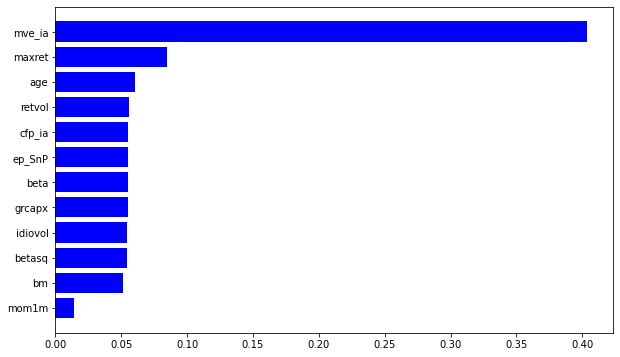

In [489]:
#NN3_R2 = np.array(R_sq_list_NN3)
#NN3_feat_imp = np.array(cum_feat_imp_NN3)

#cum_feat_imp
cum_feat_imp_df = df.loc[0,predictor_col]
cum_feat_imp_df[predictor_col] = NN3_feat_imp_2/sum(NN3_feat_imp_2)
cum_feat_imp_df
# PLot the normalized average feature importance in the 30 training samples
feat_imp = cum_feat_imp_df.sort_values(ascending=False)
feat_imp_to_plot = feat_imp[0:12].sort_values(ascending=True)

# Plot the feature importances in horizontal bar charts
import matplotlib.pyplot as plt
plt.figure(figsize = (10, 6))
ax = plt.subplot()
ax.barh(list(feat_imp_to_plot.index),
    feat_imp_to_plot, 
    align = 'center', color = 'blue')

In [419]:
##### Define the class for NN4

class NN4(Module):
    def __init__(self, input_size, hidden_size_1, hidden_size_2, hidden_size_3, hidden_size_4):
        super(NN4, self).__init__()
        self.input_size = input_size
        self.hidden_size_1  = hidden_size_1
        self.hidden_size_2  = hidden_size_2
        self.hidden_size_3  = hidden_size_3
        self.hidden_size_4  = hidden_size_4
        self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size_1)
        self.relu = torch.nn.ReLU()
        self.bn1 = nn.BatchNorm1d(self.hidden_size_1)
        self.fc2 = torch.nn.Linear(self.hidden_size_1, self.hidden_size_2)
        self.bn2 = nn.BatchNorm1d(self.hidden_size_2)
        self.fc3 = torch.nn.Linear(self.hidden_size_2, self.hidden_size_3)
        self.bn3 = nn.BatchNorm1d(self.hidden_size_3)
        self.fc4 = torch.nn.Linear(self.hidden_size_3, self.hidden_size_4)
        self.bn4 = nn.BatchNorm1d(self.hidden_size_4)
        self.output = nn.Linear(self.hidden_size_4, 1)
    def forward(self, x):
        hidden = self.fc1(x)
        relu = self.relu(hidden)
        bn_x = self.bn1(relu)
        hidden = self.fc2(bn_x)
        relu = self.relu(hidden)
        bn_x = self.bn2(relu)
        hidden = self.fc3(bn_x)
        relu = self.relu(hidden)
        bn_x = self.bn3(relu)
        hidden = self.fc4(bn_x)
        relu = self.relu(hidden)
        bn_x = self.bn4(relu)
        output = self.output(bn_x)
        return output

net4 = NN4(input_size=177, hidden_size_1=32, hidden_size_2=16, hidden_size_3=8, hidden_size_4=4).to(device)
print(net4)

NN4(
  (fc1): Linear(in_features=177, out_features=32, bias=True)
  (relu): ReLU()
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=32, out_features=16, bias=True)
  (bn2): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=16, out_features=8, bias=True)
  (bn3): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc4): Linear(in_features=8, out_features=4, bias=True)
  (bn4): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (output): Linear(in_features=4, out_features=1, bias=True)
)


In [236]:
### Training for NN4
learning_rate = 5e-3
# l1 regularization
l1_lambda = 1e-5
epsilon = 0.0005
train_model(net4, data_train, data_valid, learning_rate, l1_lambda, epsilon)

Epoch 1 : Training MSE Loss : 3.3649988174438477
Epoch 1 Validation R^2_oos : 0.0780753493309021
Epoch 2 : Training MSE Loss : 1.0662082433700562
Epoch 2 Validation R^2_oos : 0.11865705251693726
Epoch 3 : Training MSE Loss : 1.0139415264129639
Epoch 3 Validation R^2_oos : 0.1251511573791504
Epoch 4 : Training MSE Loss : 0.9980990886688232
Epoch 4 Validation R^2_oos : 0.12443691492080688
Epoch 5 : Training MSE Loss : 0.9975364804267883
Epoch 5 Validation R^2_oos : 0.12297779321670532
Epoch 6 : Training MSE Loss : 0.9902791380882263
Epoch 6 Validation R^2_oos : 0.11890459060668945
Epoch 7 : Training MSE Loss : 0.9903302788734436
Epoch 7 Validation R^2_oos : 0.11546593904495239
Epoch 8 : Training MSE Loss : 0.9851861596107483
Epoch 8 Validation R^2_oos : 0.11488866806030273
Early stopping triggered and the best validation R^2: 0.1251511573791504
Trainin stopped after 8 epochs


In [67]:
### Training for NN4 with the full dataset (training + validation set)
train_model(net4, data_train_full, data_test, learning_rate, l1_lambda, epsilon)

Epoch 1 : Training MSE Loss : 2.937375068664551
Epoch 1 Validation R^2_oos : 0.08512461185455322
Epoch 2 : Training MSE Loss : 2.9446606636047363
Epoch 2 Validation R^2_oos : 0.08020991086959839
Epoch 3 : Training MSE Loss : 2.9041643142700195
Epoch 3 Validation R^2_oos : 0.07446169853210449
Epoch 4 : Training MSE Loss : 2.8876259326934814
Epoch 4 Validation R^2_oos : 0.07079464197158813
Epoch 5 : Training MSE Loss : 2.8781983852386475
Epoch 5 Validation R^2_oos : 0.06938886642456055
Epoch 6 : Training MSE Loss : 2.8613812923431396
Epoch 6 Validation R^2_oos : 0.07069742679595947
Early stopping triggered and the best validation R^2: 0.08512461185455322
Trainin stopped after 6 epochs


In [238]:
torch.save(net4.state_dict(), "NN4.pt")

In [237]:
test_model(net4, data_test)

R_sq_oos in the following year:


tensor(0.1035, grad_fn=<RsubBackward1>)

In [465]:
# Define a recursive training loop for NN4
BATCH_SIZE = 10000
### Training for NN4
learning_rate = 5e-3
# l1 regularization
l1_lambda = 1e-4
epsilon = 0.001

for year in range(1975,2005):
    data = stock_data(stockdata=df.loc[df['yyyymm']//100 < year,:].reset_index().iloc[:,1:], predictor_col=predictor_col)
    data_train = DataLoader(dataset = data, batch_size = BATCH_SIZE, drop_last=True, shuffle=False)
    del(data)
    
    dataset_valid = stock_data(stockdata=df.loc[((df['yyyymm']//100 >= year)&(df['yyyymm']//100 < year+12)),:].reset_index().iloc[:,1:], predictor_col=predictor_col)
    data_valid = DataLoader(dataset = dataset_valid, batch_size = BATCH_SIZE, drop_last=True, shuffle=False)
    del(dataset_valid)
    
    net = NN4(input_size=177, hidden_size_1=32, hidden_size_2=16, hidden_size_3=8, hidden_size_4=4).to(device)
    train_model(net, data_train, data_valid, learning_rate, l1_lambda, epsilon, printout=False)
    
    del(data_train)
    del(data_valid)
    gc.collect()
    
    filename = "NN4_" + str(year+12) + "_end.pt"
    print(filename)
    torch.save(net.state_dict(), filename)
    del(net)

NN4_1997_end.pt
NN4_1998_end.pt
NN4_1999_end.pt
NN4_2000_end.pt
NN4_2001_end.pt
NN4_2002_end.pt
NN4_2003_end.pt
NN4_2004_end.pt
NN4_2005_end.pt
NN4_2006_end.pt
NN4_2007_end.pt
NN4_2008_end.pt
NN4_2009_end.pt
NN4_2010_end.pt
NN4_2011_end.pt
NN4_2012_end.pt
NN4_2013_end.pt
NN4_2014_end.pt
NN4_2015_end.pt
NN4_2016_end.pt


In [468]:
R_sq_list_NN4 = []
cum_feat_imp_NN4 = np.zeros(len(predictor_col))

for year in range(1987,2016):
    
    net4 = NN4(input_size=177, hidden_size_1=32, hidden_size_2=16, hidden_size_3=8, hidden_size_4=4).to(device)
    filename = "NN4_" + str(year) + "_end.pt"
    net4.load_state_dict(torch.load(filename))
    year_test_start = year
    
    # Note the coming 12 years of data are for validation but not for testing or model estimates
    # So we test the model fitted with 1957-1974 data with 1987 data, and so on
    dataset_test = stock_data(stockdata=df[((df['yyyymm']//100 >= year_test_start) & (df['yyyymm']//100 < year_test_start+1))], predictor_col=predictor_col)
    data_test = DataLoader(dataset = dataset_test, batch_size = BATCH_SIZE, drop_last=True, shuffle=False)
    del dataset_test
    
    # Save the R_sq_oos for each year
    R_sq_oos = test_model(net4, data_test).item()
    R_sq_list_NN4.append(R_sq_oos)
    del(data_test)
    
    # At the same time we find the feature importance of the net
    
    year_train_end = year-12
    data = stock_data(stockdata=df[df['yyyymm']//100 < year_train_end], predictor_col=predictor_col)
    BATCH_SIZE = 10000
    data_train = DataLoader(dataset = data, batch_size = BATCH_SIZE, drop_last=True, shuffle=False)
    del(data)
    cum_feat_imp_NN4 += feat_imp_net(net4, data_train)
    del(data_train)
    print("Year {} completed".format(year))
    
R_sq_list_NN4

Year 1997 completed
Year 1998 completed
Year 1999 completed
Year 2000 completed
Year 2001 completed
Year 2002 completed
Year 2003 completed
Year 2004 completed
Year 2005 completed
Year 2006 completed
Year 2007 completed
Year 2008 completed
Year 2009 completed
Year 2010 completed
Year 2011 completed
Year 2012 completed
Year 2013 completed
Year 2014 completed
Year 2015 completed


[0.04940450191497803,
 0.06414300203323364,
 0.05964648723602295,
 0.05428183078765869,
 0.005689382553100586,
 -0.017958521842956543,
 -0.1940622329711914,
 -0.040036797523498535,
 -0.2886390686035156,
 -0.013357281684875488,
 -0.04052877426147461,
 0.04371136426925659,
 -0.009341716766357422,
 0.05293834209442139,
 -0.024434447288513184,
 -0.04148149490356445,
 -0.42702770233154297,
 -0.22869861125946045,
 0.04338568449020386,
 -0.050274014472961426,
 0.08281964063644409,
 0.10839813947677612,
 -0.08624231815338135,
 -0.0897599458694458,
 -0.08715283870697021,
 -0.1428285837173462,
 -0.16103196144104004,
 -0.16258549690246582,
 -0.027772903442382812]

In [471]:
print(np.mean(R_sq_list_NN4))
print(np.median(R_sq_list_NN4))
print(np.max(R_sq_list_NN4))
print(np.mean(R_sq_list_NN4[0:9]))
print(np.median(R_sq_list_NN4[0:9]))
print(np.max(R_sq_list_NN4[0:9]))

-0.05409642540175339
-0.027772903442382812
0.10839813947677612
-0.03417015737957425
0.005689382553100586
0.06414300203323364


In [424]:
##### Define the class for NN5

class NN5(Module):
    def __init__(self, input_size, hidden_size_1, hidden_size_2, hidden_size_3, hidden_size_4, hidden_size_5):
        super(NN5, self).__init__()
        self.input_size = input_size
        self.hidden_size_1  = hidden_size_1
        self.hidden_size_2  = hidden_size_2
        self.hidden_size_3  = hidden_size_3
        self.hidden_size_4  = hidden_size_4
        self.hidden_size_5  = hidden_size_5
        self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size_1)
        self.relu = torch.nn.ReLU()
        self.bn1 = nn.BatchNorm1d(self.hidden_size_1)
        self.fc2 = torch.nn.Linear(self.hidden_size_1, self.hidden_size_2)
        self.bn2 = nn.BatchNorm1d(self.hidden_size_2)
        self.fc3 = torch.nn.Linear(self.hidden_size_2, self.hidden_size_3)
        self.bn3 = nn.BatchNorm1d(self.hidden_size_3)
        self.fc4 = torch.nn.Linear(self.hidden_size_3, self.hidden_size_4)
        self.bn4 = nn.BatchNorm1d(self.hidden_size_4)
        self.fc5 = torch.nn.Linear(self.hidden_size_4, self.hidden_size_5)
        self.bn5 = nn.BatchNorm1d(self.hidden_size_5)
        self.output = nn.Linear(self.hidden_size_5, 1)
    def forward(self, x):
        hidden = self.fc1(x)
        relu = self.relu(hidden)
        bn_x = self.bn1(relu)
        hidden = self.fc2(bn_x)
        relu = self.relu(hidden)
        bn_x = self.bn2(relu)
        hidden = self.fc3(bn_x)
        relu = self.relu(hidden)
        bn_x = self.bn3(relu)
        hidden = self.fc4(bn_x)
        relu = self.relu(hidden)
        bn_x = self.bn4(relu)
        hidden = self.fc5(bn_x)
        relu = self.relu(hidden)
        bn_x = self.bn5(relu)
        output = self.output(bn_x)
        return output

net5 = NN5(input_size=177, hidden_size_1=32, hidden_size_2=16, hidden_size_3=8, hidden_size_4=4, hidden_size_5=2).to(device)
print(net5)

NN5(
  (fc1): Linear(in_features=177, out_features=32, bias=True)
  (relu): ReLU()
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=32, out_features=16, bias=True)
  (bn2): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=16, out_features=8, bias=True)
  (bn3): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc4): Linear(in_features=8, out_features=4, bias=True)
  (bn4): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc5): Linear(in_features=4, out_features=2, bias=True)
  (bn5): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (output): Linear(in_features=2, out_features=1, bias=True)
)


In [240]:
### Training for NN5
learning_rate = 5e-3
# l1 regularization
l1_lambda = 1e-5
epsilon = 0.0005
train_model(net5, data_train, data_valid, learning_rate, l1_lambda, epsilon)

Epoch 1 : Training MSE Loss : 3.1147713661193848
Epoch 1 Validation R^2_oos : 0.09682649374008179
Epoch 2 : Training MSE Loss : 1.0857855081558228
Epoch 2 Validation R^2_oos : 0.12495166063308716
Epoch 3 : Training MSE Loss : 1.0187106132507324
Epoch 3 Validation R^2_oos : 0.12788766622543335
Epoch 4 : Training MSE Loss : 0.9978020191192627
Epoch 4 Validation R^2_oos : 0.13164788484573364
Epoch 5 : Training MSE Loss : 0.9847981929779053
Epoch 5 Validation R^2_oos : 0.1336836814880371
Epoch 6 : Training MSE Loss : 0.9789547920227051
Epoch 6 Validation R^2_oos : 0.13331443071365356
Epoch 7 : Training MSE Loss : 0.975648820400238
Epoch 7 Validation R^2_oos : 0.13371747732162476
Epoch 8 : Training MSE Loss : 0.9729490280151367
Epoch 8 Validation R^2_oos : 0.13387048244476318
Epoch 9 : Training MSE Loss : 0.9704071283340454
Epoch 9 Validation R^2_oos : 0.13368433713912964
Epoch 10 : Training MSE Loss : 0.9683550000190735
Epoch 10 Validation R^2_oos : 0.13348931074142456
Early stopping trigg

In [242]:
torch.save(net5.state_dict(), "NN5.pt")

In [241]:
test_model(net5, data_test)

R_sq_oos in the following year:


tensor(0.1157, grad_fn=<RsubBackward1>)

In [ ]:
# Define a recursive training loop for NN5
BATCH_SIZE = 10000
### Training for NN5
learning_rate = 5e-3
# l1 regularization
l1_lambda = 1e-4
epsilon = 0.001

# Here year represents 
for year in range(1975,2005):
    data = stock_data(stockdata=df.loc[df['yyyymm']//100 < year,:].reset_index().iloc[:,1:], predictor_col=predictor_col)
    data_train = DataLoader(dataset = data, batch_size = BATCH_SIZE, drop_last=True, shuffle=False)
    del(data)
    
    dataset_valid = stock_data(stockdata=df.loc[((df['yyyymm']//100 >= year)&(df['yyyymm']//100 < year+12)),:].reset_index().iloc[:,1:], predictor_col=predictor_col)
    data_valid = DataLoader(dataset = dataset_valid, batch_size = BATCH_SIZE, drop_last=True, shuffle=False)
    del(dataset_valid)
    
    net = NN5(input_size=177, hidden_size_1=32, hidden_size_2=16, hidden_size_3=8, hidden_size_4=4, hidden_size_5=2).to(device)
    train_model(net, data_train, data_valid, learning_rate, l1_lambda, epsilon, printout=False)
    
    del(data_train)
    del(data_valid)
    gc.collect()
    
    filename = "NN5_" + str(year+12) + "_end.pt"
    print(filename)
    torch.save(net.state_dict(), filename)
    del(net)

In [ ]:
R_sq_list_NN5 = []
cum_feat_imp_NN5 = np.zeros(len(predictor_col))

for year in range(1987,2016):
    
    net5 = NN5(input_size=177, hidden_size_1=32, hidden_size_2=16, hidden_size_3=8, hidden_size_4=4, hidden_size_5=2).to(device)
    filename = "NN5_" + str(year) + "_end.pt"
    net5.load_state_dict(torch.load(filename))
    year_test_start = year
    
    # Note the coming 12 years of data are for validation but not for testing or model estimates
    # So we test the model fitted with 1957-1974 data with 1987 data, and so on
    dataset_test = stock_data(stockdata=df[((df['yyyymm']//100 >= year_test_start) & (df['yyyymm']//100 < year_test_start+1))], predictor_col=predictor_col)
    data_test = DataLoader(dataset = dataset_test, batch_size = BATCH_SIZE, drop_last=True, shuffle=False)
    del dataset_test
    
    # Save the R_sq_oos for each year
    R_sq_oos = test_model(net5, data_test).item()
    R_sq_list_NN5.append(R_sq_oos)
    del(data_test)
    
    # At the same time we find the feature importance of the net
    
    year_train_end = year-12
    data = stock_data(stockdata=df[df['yyyymm']//100 < year_train_end], predictor_col=predictor_col)
    BATCH_SIZE = 10000
    data_train = DataLoader(dataset = data, batch_size = BATCH_SIZE, drop_last=True, shuffle=False)
    del(data)
    cum_feat_imp_NN5 += feat_imp_net(net5, data_train)
    del(data_train)
    print("Year {} completed".format(year))
    
R_sq_list_NN5

In [100]:
####################################################################################################
##################################### 6. Elastic Net   #############################################
####################################################################################################
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import SGDRegressor
from numpy import unravel_index
import pickle
from sklearn.model_selection import GridSearchCV

In [11]:
## Build the Elastic Net model and fit
# After filling nan with cross-sectional medians and doing de-means, we fill the rest of nan with zeros
# This can be skipped if you have already done this in other sections
df = df.fillna(0)  

In [217]:
# We fit our data to the first training sample
year1 = 1957
year2 = 1975
index_start = np.min(df[df['yyyymm']//100 >=year1].index.to_list())
index_end = np.max(df[df['yyyymm']//100 <=year2].index.to_list())
#print(index_start)
#index_end

In [218]:
index_valid_end = np.max(df[df['yyyymm']//100 <=year2+12].index.to_list())
index_test_end = np.max(df[df['yyyymm']//100 <=year2+13].index.to_list())
#print(index_valid_end)
index_test_end

1419282

In [219]:
model2 = SGDRegressor(loss='huber',penalty='elasticnet',alpha=1e-3,l1_ratio=0.5, epsilon=0.05,max_iter=1e6,shuffle=False)
model2.fit(X=df.loc[:index_end,predictor_col].values, y=df.loc[:index_end,'excess_return'].values)

SGDRegressor(alpha=0.001, epsilon=0.05, l1_ratio=0.5, loss='huber',
             max_iter=1000000.0, penalty='elasticnet', shuffle=False)

In [220]:
y_hat = model2.predict(df.loc[(index_end+1):index_valid_end,predictor_col].values)
y_hat
error = y_hat-df.loc[(index_end+1):index_valid_end,'excess_return'].values
y = df.loc[(index_end+1):index_valid_end,'excess_return'].values
R_sq_oos_ENet_valid = 1-sum(error*error)/sum(y*y)
R_sq_oos_ENet_valid

0.1406791900060662

In [221]:
model2.predict(df.loc[(index_end+1):index_valid_end,predictor_col].values)

array([-0.05551768, -0.05897161, -0.07056275, ..., -0.0608321 ,
       -0.06301658, -0.07021729])

In [213]:
# Save this model to a file
filename = 'ElasticNet_1975_end.sav'
pickle.dump(model2, open(filename, 'wb'))
loaded_model = pickle.load(open(filename, 'rb'))

In [78]:
# We do a mini-grid search to fine-tune the parameters
alpha_list = [1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]
epsilon_list = [2,1.5,1,0.5,0.25,0.1,0.05,0.01]
R_sq_table_on_paras = np.zeros((len(alpha_list),len(epsilon_list)))
row_count, col_count = 0, 0
for i in range(0,len(alpha_list)):
    for j in range(0,len(epsilon_list)):
        model2 = SGDRegressor(loss='huber',penalty='elasticnet',alpha=alpha_list[i],l1_ratio=0.5, epsilon=epsilon_list[j],max_iter=1e6,shuffle=False)
        model2.fit(X=df.loc[:index_end,predictor_col], y=df.loc[:index_end,'excess_return'])
        
        # Compute validation R_sq_oos
        y_hat = model2.predict(df.loc[(index_end+1):index_valid_end,predictor_col])
        error = y_hat-df.loc[(index_end+1):index_valid_end,'excess_return'].values
        y = df.loc[(index_end+1):index_valid_end,'excess_return'].values
        R_sq_oos_ENet_valid = 1-sum(error*error)/sum(y*y)
        R_sq_table_on_paras[i,j] = R_sq_oos_ENet_valid

In [79]:
print(R_sq_table_on_paras)
unravel_index(R_sq_table_on_paras.argmax(), R_sq_table_on_paras.shape)
# Going down the row is alpha, going from left to right is epsilon

[[ 0.13437115  0.13437136  0.13449889  0.13572966  0.13830325  0.14057917
   0.14105062  0.14155384]
 [ 0.13437115  0.13437136  0.13449889  0.13572966  0.13832375  0.14060679
   0.14105062  0.14155384]
 [ 0.134473    0.13452549  0.13464561  0.13585127  0.13837606  0.14060679
   0.14106374  0.14158759]
 [ 0.13467633  0.13462766  0.13474415  0.13593484  0.13843307  0.14065455
   0.14106462  0.14163717]
 [ 0.13655382  0.13671244  0.13654115  0.13693827  0.13855844  0.14070149
   0.14083425  0.14164336]
 [ 0.13661396  0.12738323  0.13696857  0.13779884  0.14005244  0.12979707
   0.14161019  0.14164712]
 [ 0.13318272  0.13375284  0.13385425  0.13562613  0.1387106   0.13035376
   0.14067919  0.13858187]
 [ 0.13056612  0.12956469  0.12712995  0.12804904  0.13427343  0.13827315
   0.13702916  0.13853529]
 [ 0.11222691  0.11184487  0.11201977  0.11672148 -0.17594548  0.12925524
   0.13232242  0.13657232]]


(5, 7)

In [222]:
# Compute testing R_sq_oos
y_hat_test = model2.predict(df.loc[(index_valid_end+1):index_test_end,predictor_col])
error = y_hat_test-df.loc[(index_valid_end+1):index_test_end,'excess_return'].values
y = df.loc[(index_valid_end+1):index_test_end,'excess_return'].values
R_sq_oos_ENet_test = 1-sum(error*error)/sum(y*y)
R_sq_oos_ENet_test

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but SGDRegressor was fitted without feature names
  warnings.warn(


0.08873837088823988

In [223]:
##### Define a function to find feature importance
def feature_importance(model,data,response,predictors):
    # First calculate full model R_sq
    y_hat = model.predict(data.loc[:,predictors].values)
    y = data.loc[:,response].values
    error = y_hat-y
    R_sq = 1-sum(error*error)/sum(y*y)
    #print(R_sq)
    
    # Create a empty data for storing the feature importance
    R_sq_loss_table = data.loc[0,predictors]
    R_sq_loss_table[predictors] = 0
    
    for pred in predictors:
        # We adjust the y_hat by removing the term corresponding feature x features weight
        y_hat_new = y_hat - model.coef_[predictor_col.index(pred)]*data[pred]
        error_new = y_hat_new-y
        R_sq_new = 1-sum(error_new*error_new)/sum(y*y)
        #print(R_sq_new)
        
        # Compute loss in R_sq
        loss_in_R2 = R_sq - R_sq_new
        R_sq_loss_table[pred] = loss_in_R2
    
    R_sq_loss_table = R_sq_loss_table/sum(R_sq_loss_table)
    return R_sq_loss_table


In [246]:
### We do a recursive training and performance evaluation for elastic net
### This process takes roughly 4-5 hours

R_sq_list = []
cum_feat_imp = df.loc[0,predictor_col]
cum_feat_imp[predictor_col] = 0

for year in range(1975,2005):
    train_index_end = np.max(df[df['yyyymm']//100 <year].index.to_list())
    model2 = SGDRegressor(loss='huber',penalty='elasticnet',alpha=1e-3,l1_ratio=0.5, epsilon=0.05,max_iter=1e6,shuffle=False)
    model2.fit(X=df.loc[:train_index_end,predictor_col].values, y=df.loc[:train_index_end,'excess_return'].values)
    
    #Save the model, where the filename contains the last year of the training data set
    filename = 'ElasticNet_' + str(year) + '_end.sav'
    pickle.dump(model2, open(filename, 'wb'))
    
    # Note the coming 12 years of data are for validation but not for testing or model estimates
    # So we test the model fitted with 1957-1974 data with 1987 data, and so on
    test_index_start = np.max(df[df['yyyymm']//100 <year+12].index.to_list())+1
    test_index_end = np.max(df[df['yyyymm']//100 <year+13].index.to_list())
    y_hat_test = model2.predict(df.loc[test_index_start:test_index_end,predictor_col].values)
    y = df.loc[test_index_start:test_index_end,'excess_return'].values
    error = y_hat_test-y
    R_sq_oos_ENet_test = 1-sum(error*error)/sum(y*y)
    R_sq_list.append(R_sq_oos_ENet_test)
    
    # Feature Importance
    feat_imp = feature_importance(model=model2,data=df.loc[:train_index_end,:],response='excess_return',predictors=predictor_col)
    cum_feat_imp += feat_imp
    print("Year ended {} training completed".format(year))
    del(model2)

Year ended 1975 training completed
Year ended 1976 training completed
Year ended 1977 training completed
Year ended 1978 training completed
Year ended 1979 training completed
Year ended 1980 training completed
Year ended 1981 training completed
Year ended 1982 training completed
Year ended 1983 training completed
Year ended 1984 training completed
Year ended 1985 training completed
Year ended 1986 training completed
Year ended 1987 training completed
Year ended 1988 training completed
Year ended 1989 training completed
Year ended 1990 training completed
Year ended 1991 training completed
Year ended 1992 training completed
Year ended 1993 training completed
Year ended 1994 training completed
Year ended 1995 training completed
Year ended 1996 training completed
Year ended 1997 training completed
Year ended 1998 training completed
Year ended 1999 training completed
Year ended 2000 training completed
Year ended 2001 training completed
Year ended 2002 training completed
Year ended 2003 trai

In [135]:
loaded_model = pickle.load(open('ElasticNet_1989_end.sav', 'rb'))
#feat_imp = feature_importance(model=loaded_model,data=df.loc[:index_end,:],response='excess_return',predictors=predictor_col)
alpha_best = loaded_model.best_params_['alpha']
epsilon_best = loaded_model.best_params_['epsilon']
model2 = SGDRegressor(loss='huber',penalty='elasticnet',l1_ratio=0.5,alpha=alpha_best, epsilon=epsilon_best,max_iter=1e6,shuffle=False)
model2.fit(X=df.loc[:index_end,predictor_col].values, y=df.loc[:index_end,'excess_return'].values)

SGDRegressor(alpha=0.001, epsilon=0.01, l1_ratio=0.5, loss='huber',
             max_iter=1000000.0, penalty='elasticnet', shuffle=False)

In [102]:
y_hat_test = model_gs.predict(df.loc[(index_valid_end+1):index_test_end,predictor_col])
error = y_hat_test-df.loc[(index_valid_end+1):index_test_end,'excess_return'].values
y = df.loc[(index_valid_end+1):index_test_end,'excess_return'].values
R_sq_oos_ENet_test = 1-sum(error*error)/sum(y*y)
R_sq_oos_ENet_test

0.08981932579571605

In [96]:
loaded_model = pickle.load(open('ElasticNet_1989_end.sav', 'rb'))
test_index_start = np.max(df[df['yyyymm']//100 <=1989].index.to_list())+1
test_index_end = np.max(df[df['yyyymm']//100 <=1990].index.to_list())

y_hat_test = loaded_model.predict(df.loc[test_index_start:test_index_end,predictor_col])
y = df.loc[test_index_start:test_index_end,'excess_return'].values
error = y_hat_test-y
R_sq_oos_ENet_test = 1-sum(error*error)/sum(y*y)
R_sq_oos_ENet_test

0.14867141597362843

In [248]:
cum_feat_imp.sort_values(ascending=False)/30

mom1m       0.306123
retvol      0.207962
age         0.194719
mom12m      0.076180
ms          0.063263
              ...   
tb          0.000000
aeavol      0.000000
sic2_nan    0.000000
chmom      -0.000002
idiovol    -0.072731
Name: 0, Length: 177, dtype: float64

<BarContainer object of 12 artists>

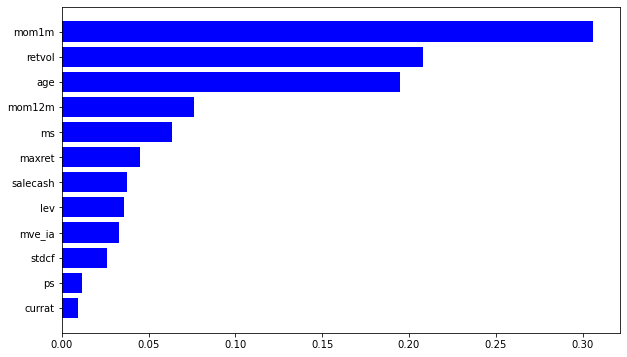

In [253]:
# PLot the normalized average feature importance in the 30 training samples
feat_imp = cum_feat_imp.sort_values(ascending=False)/30
feat_imp_to_plot = feat_imp[0:12].sort_values(ascending=True)

# Plot the feature importances in horizontal bar charts
import matplotlib.pyplot as plt
plt.figure(figsize = (10, 6))
ax = plt.subplot()
ax.barh(list(feat_imp_to_plot.index),
    feat_imp_to_plot, 
    align = 'center', color = 'blue')

In [ ]:
import scipy.stats
print(np.max(R_sq_list))
print(np.median(R_sq_list))
scipy.stats.trim_mean(R_sq_list, 0.1)